<a href="https://colab.research.google.com/github/kochlisGit/Physics-Informed-Neural-Network-PINN-/blob/main/TF_PINN_Higher_Order_PDEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this example, I will use **Tensorflow v2** to train a *Physics-Informed Neural Network* (*PINN*) model to solve a second order PDE. Higher-order PDEs are a bit more diffucult than first-order PDEs, because they involve the Hessian Matrix computation. Additionally, the boundary conditions could also be dependent from the derivative of $y$ (also known as *Neumann* BCs), which is of course not known. 
The equation I will solve is $\frac{d^2y}{dx^2} = -\pi^2 sin(\pi x)$ with $y(0) = 0$ and $\frac{dy}{dx}(0) = \pi$ for interval $x \in [0, 2 \pi]$ . For evaluation purposes only, we know that the solution of this equation is $y=sin(\pi x)$.

In [1]:
import tensorflow as tf
import numpy as np

In [175]:
num_domain = 1000
num_test = 100
minval = 0
maxval = 2*np.pi

def generate_uniform_data(num_domain, minval, maxval):
  data_init = tf.random_uniform_initializer(minval=minval, maxval=maxval, seed=0)
  return tf.Variable(data_init(shape=[num_domain, 1]), dtype=tf.float32)

x_train = generate_uniform_data(num_domain, minval, maxval)
x_test = generate_uniform_data(num_test, minval, maxval)
x_train.shape, x_test.shape

(TensorShape([1000, 1]), TensorShape([100, 1]))

In order to compute the error of our neural network, we are going to have to compute the derivatives of $\frac{dy}{dx}$ and $\frac{d^2y}{dx^2}$. In the previous example, I used the *GradientTape* object to compute Jacobian Matrix of this PDE. In this example, I also need to compute the Hessian Matrix as well.

# Jabocian Matrix

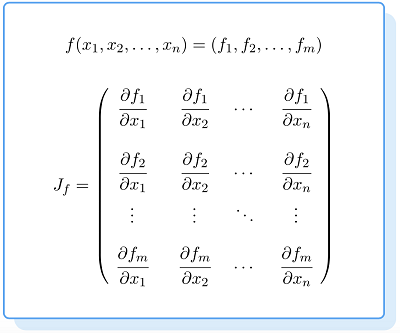

# Hessian Matrix

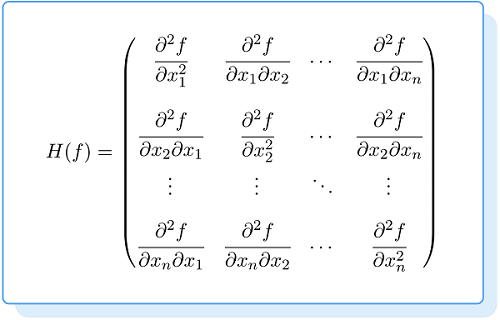

In [174]:
def jacobian(tape, y, x, i=0, j=0):
  if y.shape[1] > 1:
    y = y[:, i : i + 1]

  grads = tape.gradient(y, x)
  return grads[:, j : j + 1]

def hessian(tape, y, x, i=0, j=0, component=0):
  jaboc_grads = jacobian(tape, y, x, component, i)
  hessian_grads = tape.gradient(jaboc_grads, x)
  return hessian_grads[:, j : j + 1]

$\frac{d^2y}{dx^2} = -\pi^2 sin(\pi x) \Rightarrow \frac{d^2y}{dx^2} + \pi^2 sin(\pi x) = 0$

**Domain Loss**: *MSE*($\frac{d^2y}{dx^2} + \pi^2 sin(\pi x)$)

**$BC_1$ Loss**: *MSE*($y(0)$)

**$BC_2$ Loss**: *MSE*($y(2\pi) - 1$)

Training Loss = Domain Loss + $BC_1$ Loss + $BC_1$ Loss

In [176]:
def pde(tape, x, y):
  dyy_x = hessian(tape, y, x)
  return dyy_x + np.pi**2 * tf.sin(np.pi*x)

def dirichlet_bc_0(x):
  return 0

def neumann_bc_2pi(x):
  return 1

x_0 = tf.constant(0, shape=[1,1], dtype=tf.float32)
x_2pi = tf.Variable([[2*np.pi]], trainable=True, dtype=tf.float32)

In [177]:
n_inputs = 1
n_outputs = 1
hidden_units = [50, 50, 50]
activation = 'tanh'

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input((n_inputs,)))

for units in hidden_units:
  model.add(tf.keras.layers.Dense(units=units, activation=activation))

model.add(tf.keras.layers.Dense(units=n_outputs))
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_89 (Dense)            (None, 50)                100       
                                                                 
 dense_90 (Dense)            (None, 50)                2550      
                                                                 
 dense_91 (Dense)            (None, 50)                2550      
                                                                 
 dense_92 (Dense)            (None, 1)                 51        
                                                                 
Total params: 5,251
Trainable params: 5,251
Non-trainable params: 0
_________________________________________________________________


In [178]:
epochs = 10000
learning_rate = 0.0005

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

for i in range(epochs + 1):
  with tf.GradientTape() as tape_model:
    with tf.GradientTape() as neumann_tape:
      y_2pi = model(x_2pi, training=True)
      dy_2pi = neumann_tape.gradient(y_2pi, x_2pi)[0][0]
      bc2_error = dy_2pi - neumann_bc_2pi(x_2pi)

    with tf.GradientTape(persistent=True) as tape_pde:
      y = model(x_train, training=True)
      y_0 = model(x_0, training=True)[0][0]

      domain_error = pde(tape_pde, x_train, y)
      bc1_error = y_0 - dirichlet_bc_0(x_0)

    domain_mse = mse = tf.math.reduce_mean(tf.math.square(domain_error), axis=0)
    bc1_mse =  tf.math.square(bc1_error)
    bc2_mse = tf.math.square(bc2_error)
    total_mse = domain_mse + bc1_mse + bc2_mse
    total_mse = domain_mse + bc1_mse

  model_update_gradients = tape_model.gradient(total_mse, model.trainable_variables)
  optimizer.apply_gradients(
    zip(model_update_gradients, model.trainable_variables)
  )

  del tape_pde

  if i % 1000 == 0:
    y_preds = model(x_test)
    test_mse = tf.math.reduce_mean(tf.math.square(y_preds - tf.math.sin(np.pi*x_test)), axis=0)
    print('Epoch: {}\tTrain Loss = {},\tTest Loss = {}'.format(i, total_mse.numpy()[0], test_mse.numpy()[0]))

Epoch: 0	Train Loss = 48.862186431884766,	Test Loss = 0.587417721748352
Epoch: 1000	Train Loss = 2.308623790740967,	Test Loss = 8.27248477935791
Epoch: 2000	Train Loss = 0.20691749453544617,	Test Loss = 0.29902949929237366
Epoch: 3000	Train Loss = 0.0030946829356253147,	Test Loss = 0.785431981086731
Epoch: 4000	Train Loss = 0.0025441329926252365,	Test Loss = 0.7356426119804382
Epoch: 5000	Train Loss = 0.0023016221821308136,	Test Loss = 0.6306663751602173
Epoch: 6000	Train Loss = 0.0031717512756586075,	Test Loss = 0.4825534522533417
Epoch: 7000	Train Loss = 0.0013415836729109287,	Test Loss = 0.31047695875167847
Epoch: 8000	Train Loss = 0.006727862171828747,	Test Loss = 0.15140220522880554
Epoch: 9000	Train Loss = 0.0007537984638474882,	Test Loss = 0.03846774250268936
Epoch: 10000	Train Loss = 0.000551923003513366,	Test Loss = 5.0272898079128936e-05


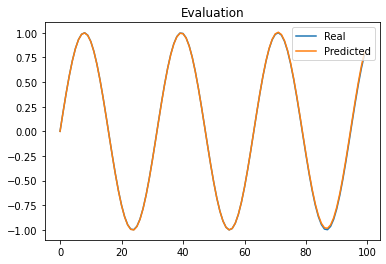

In [179]:
import numpy as np
import matplotlib.pyplot as plt

x_test = np.linspace(0, 2*np.pi, 100)
y_true = np.sin(np.pi*x_test)
y_pred = model(x_test)

plt.plot(y_true)
plt.plot(y_pred)
plt.title('Evaluation')
plt.legend(['Real', 'Predicted'])
plt.show()